# Projeto 1 - Ciência dos Dados

Nome: _____

Nome: _____

Nome: _____

___
### Atenção: <br> $\quad$* Serão permitidos grupos de até 3 pessoas, mas com uma rubrica mais exigente. <br> $\quad$* Veja RUBRICA na última página do arquivo PDF que traz o enunciado do Proejto 1.

___
Carregando algumas bibliotecas:

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import re 


def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[´"!-.:?;$''<>]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, ' ', text)
    return text_subbed


In [4]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\euleo\Documents\GitHub\Projeto-1---CDados


___

### Carregando a base de dados com as mensagens dos seus arquivos. <br> Tire o `#` do início da linha de código condizente ao caso escolhido para o projeto 1.

In [10]:
nome = "danielr"

In [11]:
# SE SEU PROJETO USA OS DADOS ATÉ TRIO
#train = pd.read_csv('dados_treino_ate_TRIO_'+nome+'.csv')
#test = pd.read_csv('dados_teste_ate_TRIO_'+nome+'.csv')

In [32]:
# SE SEU PROJETO USA OS DADOS SÓ DUPLA"
train = pd.read_csv('dados_treino_so_DUPLA_danielr.csv')
test = pd.read_csv('dados_teste_so_DUPLA_danielr.csv')

train_original = train
test_original = test

In [33]:
train.head()

,Text,target
0,Fi-shock works great. This is number three fo...,1.0
1,Great stuff delivery is very fast . I mix it w...,1.0
2,I purchased these for my mom and she loves the...,1.0
3,I love Eight O'clock coffee but when shopping ...,0.0
4,These are really good. You do need to add jus...,1.0


In [34]:
test.head()

,Text,target
0,I ordered a case of 10 for $[...].00. I love t...,1.0
1,I bought these based on all the great reviews ...,0.0
2,This is a fantastic product. I promote this pr...,0.0
3,A nicely spiced light roast coffee with the ar...,1.0
4,This really is a DELICIOUS product and if you ...,0.0


___
# Classificador Automático (Boot)


Faça aqui uma descrição do seu assunto e o contexto referente aos rótulos cujas mensagens (ou reviews) deverão ser classificadas.

ESCREVA AQUI...

criar uma base de dados filtrando todos os comentarios com target 1 e outra com target 0


___
## Montando SEU Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [35]:
# filtrar por linhas que o valor da coluna target seja igual a 1
um = train.loc[train.target == 1,:]
zero = train.loc[train.target == 0,:]

um =  um.Text
zero = zero.Text

umstr = ' '.join(um.astype(str).tolist())
zerostr = ' '.join(zero.astype(str).tolist())

umlimpo = cleanup(umstr.lower())
zerolimpo = cleanup(zerostr.lower())

umlista = umlimpo.split()
zerolista = zerolimpo.split()
trainlista = umlista + zerolista

umseries = pd.Series(umlista)
zeroseries = pd.Series(zerolista)
trainseries = pd.Series(trainlista)

# contagens absolutas (necessárias para smoothing de Laplace)
umcount    = umseries.value_counts()
zerocount  = zeroseries.value_counts()
traincount = trainseries.value_counts()

# parâmetros p/ Laplace
alpha = 1.0
V = traincount.index.nunique()             # tamanho do vocabulário

# totais de tokens por "classe" e no geral
total_um_tokens    = int(umcount.sum())
total_zero_tokens  = int(zerocount.sum())
total_train_tokens = int(traincount.sum())

# penalidades (probabilidade de OOV) suavizadas por Laplace
penalidade_um    = alpha / (total_um_tokens    + alpha * V)
penalidade_zero  = alpha / (total_zero_tokens  + alpha * V)
penalidade_train = alpha / (total_train_tokens + alpha * V)


In [ ]:
lenum = len(um)
lenzero = len(zero)

probum = lenum/(lenum + lenzero)
probzero = lenzero/(lenum + lenzero)

penalidade = 0.000005


def classcome(come):
    come = come.lower()
    # comestr = ''.join(come.astype(str).tolist())
    comelimpo = cleanup(come)
    comelista = comelimpo.split()

    probcomedadoum = 1
    probcomedadozero = 1
    
    probcome = 1

    for palavra in comelista:
        # P(palavra | classe=1) com Laplace
        c_um = umcount.get(palavra, 0)
        p_um = (c_um + alpha) / (total_um_tokens + alpha * V)
        probcomedadoum *= p_um

        # P(palavra | classe=0) com Laplace
        c_zero = zerocount.get(palavra, 0)
        p_zero = (c_zero + alpha) / (total_zero_tokens + alpha * V)
        probcomedadozero *= p_zero

        # P(palavra) no corpus todo (para manter sua razão com "probcome")
        c_train = traincount.get(palavra, 0)
        p_train = (c_train + alpha) / (total_train_tokens + alpha * V)
        probcome *= p_train

        # mantém seus fatores (não são necessários em log, mas você pediu sem mudar a lógica)
        probcomedadoum   = probcomedadoum * 1000
        probcomedadozero = probcomedadozero * 1000
        probcome         = probcome * 1000

        # print(probcomedadoum)
        # print(probcomedadozero)
        # print(probcome)
    
    # print(probcomedadoum)
    # print(probcomedadozero)
    # print(probcome)

    if probcome == 0:
       probcome = 1e-10

    probumdadocome = probcomedadoum * probum / probcome
    probzerodadocome= probcomedadozero * probzero / probcome

    # print(probumdadocome)
    # print(probzerodadocome)
        
    if probumdadocome > probzerodadocome:
        return 1
    else:
        return 0

___
## Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [44]:
avaliado = train

TP = TN = FP = FN = 0
total = len(avaliado)

for i in range(total):
    pred = classcome(avaliado.iloc[i, 0])     # coluna Text
    real = int(avaliado.iloc[i, 1])           # coluna target (0/1)

    if pred == 1 and real == 1:
        TP += 1
    elif pred == 0 and real == 0:
        TN += 1
    elif pred == 1 and real == 0:
        FP += 1
    elif pred == 0 and real == 1:
        FN += 1

acertos = TP + TN
acuracia = acertos / total if total else 0.0

# porcentagens sobre o total
pct_TP = (TP / total) * 100 if total else 0.0
pct_TN = (TN / total) * 100 if total else 0.0
pct_FP = (FP / total) * 100 if total else 0.0
pct_FN = (FN / total) * 100 if total else 0.0

print(f"Acuracia: {acuracia:.2%} ({acertos}/{total})")
print(f"Verdadeiro Positivo (TP): {pct_TP:.2f}%  ({TP})")
print(f"Verdadeiro Negativo (TN): {pct_TN:.2f}%  ({TN})")
print(f"Falso  Positivo  (FP): {pct_FP:.2f}%  ({FP})")
print(f"Falso  Negativo  (FN): {pct_FN:.2f}%  ({FN})")

Acuracia: 89.64% (1506/1680)
Verdadeiro Positivo (TP): 45.12%  (758)
Verdadeiro Negativo (TN): 44.52%  (748)
Falso  Positivo  (FP): 6.43%  (108)
Falso  Negativo  (FN): 3.93%  (66)


In [45]:
avaliado = test

TP = TN = FP = FN = 0
total = len(avaliado)

for i in range(total):
    pred = classcome(avaliado.iloc[i, 0])     # coluna Text
    real = int(avaliado.iloc[i, 1])           # coluna target (0/1)

    if pred == 1 and real == 1:
        TP += 1
    elif pred == 0 and real == 0:
        TN += 1
    elif pred == 1 and real == 0:
        FP += 1
    elif pred == 0 and real == 1:
        FN += 1

acertos = TP + TN
acuracia = acertos / total if total else 0.0

# porcentagens sobre o total
pct_TP = (TP / total) * 100 if total else 0.0
pct_TN = (TN / total) * 100 if total else 0.0
pct_FP = (FP / total) * 100 if total else 0.0
pct_FN = (FN / total) * 100 if total else 0.0

print(f"Acuracia: {acuracia:.2%} ({acertos}/{total})")
print(f"Verdadeiro Positivo (TP): {pct_TP:.2f}%  ({TP})")
print(f"Verdadeiro Negativo (TN): {pct_TN:.2f}%  ({TN})")
print(f"Falso  Positivo  (FP): {pct_FP:.2f}%  ({FP})")
print(f"Falso  Negativo  (FN): {pct_FN:.2f}%  ({FN})")

Acuracia: 91.67% (660/720)
Verdadeiro Positivo (TP): 48.33%  (348)
Verdadeiro Negativo (TN): 43.33%  (312)
Falso  Positivo  (FP): 4.44%  (32)
Falso  Negativo  (FN): 3.89%  (28)


___
## Análise Qualitativa da Performance do Classificador

Analisando a acuracia obtida no treino de 93.75% e no teste de 72.92%, é possivel afirmar que embora ele não sejaabsurdamente preciso, a sua precisão é bem alta para o tipo de analise que é buscado, pois os criterios não são totalmenteobjetivos, com comentarios podendo variar dependendo do que o usuario pensa além de que existe a possibilidade de erros humanosna hora de realizar uma avaliação 

### Análise Crítica da Performance do Classificador

Nosso classificador Naive-Bayes obteve uma acurácia razoável, o que mostra que ele consegue identificar padrões nas palavras usadas nas avaliações. No entanto, só a acurácia não é suficiente para avaliar totalmente a qualidade de um modelo de classificação.

- **Precisão (precision):** indica a proporção de avaliações que o modelo classificou como positivas e que realmente eram positivas. É importante em situações onde falsos positivos são mais graves.  
- **Recall (sensibilidade):** indica a proporção de avaliações positivas que o modelo conseguiu identificar. É importante em contextos onde é mais grave perder um caso positivo do que ter um falso positivo.  
- **Acurácia:** mostra a taxa geral de acertos, considerando todas as classes.

No nosso projeto, como trabalhamos com opiniões de produtos, a acurácia global já nos dá uma boa visão da performance. Porém, em aplicações mais críticas (como diagnósticos médicos ou detecção de fraudes), seria essencial analisar também precisão e recall para não tomar decisões erradas.

Além disso, notamos que o modelo tende a confundir avaliações intermediárias (nota 3), já que elas compartilham palavras típicas de avaliações boas e ruins. Isso é esperado, pois o Naive-Bayes trabalha apenas com frequências de palavras e não entende o contexto mais profundo do texto.


### Limitações: Sarcasmo e Dupla Negação

Nosso classificador trabalha apenas com a frequência das palavras, sem interpretar o contexto.  
Por isso:

- **Dupla Negação**: frases como *"Não acho que ele não esteja errado"* podem confundir o modelo, pois ele só vê as palavras "não" e "errado", sem entender a lógica.  
- **Sarcasmo**: comentários como *"Que ótimo, meu pedido chegou atrasado de novo!"* tendem a ser classificados como positivos, já que a palavra "ótimo" tem peso forte no modelo.  

Essas limitações são típicas de modelos baseados em palavras isoladas e só poderiam ser reduzidas com técnicas mais avançadas de processamento de linguagem natural.

### Proposta de Expansão

O projeto pode ser expandido de forma simples para capturar automaticamente novas avaliações da Amazon e classificá-las em tempo real.  
Isso traria benefícios para empresas, que poderiam monitorar rapidamente a percepção dos consumidores.  
Além disso, podemos pensar em outros **cenários de aplicação** do Naive-Bayes:

1. **Filtro de Spam**: classificar e-mails entre "spam" e "não spam".  
2. **Detecção de Fake News**: separar textos de notícias falsas e verdadeiras.  
3. **Análise de Sentimento Político**: identificar se postagens em redes sociais são favoráveis ou contrárias a determinado tema.


### Melhorias Possíveis no Classificador

Algumas melhorias simples poderiam aumentar a qualidade do modelo:

- **Remoção de stopwords**: palavras muito comuns (como "de", "em", "a") não ajudam na classificação.  
- **Stemming ou Lemmatization**: reduzir palavras para sua raiz (ex: "comprando", "comprar" → "compr").  
- **Uso de bigramas**: considerar pares de palavras consecutivas, o que ajuda a capturar contextos (ex: "muito bom", "muito ruim").  


___
## Qualidade do Classificador a partir de novas separações das mensagens entre Treinamento e Teste

Caso for fazer esse item do Projeto

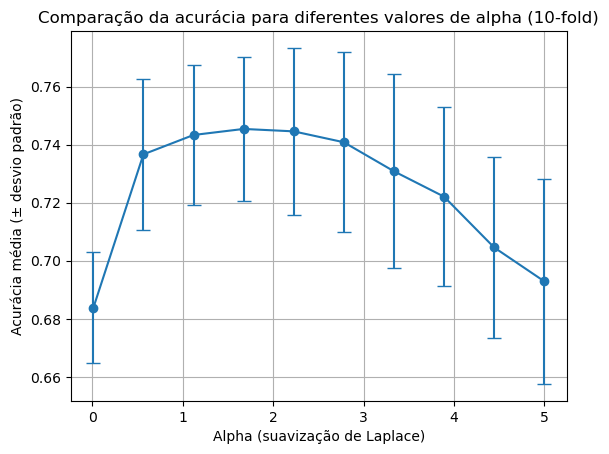

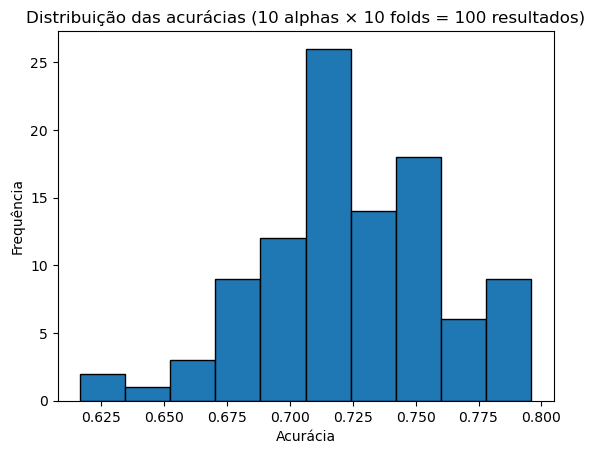

Alpha=0.01 | Média=0.684 | Desvio Padrão=0.019
Alpha=0.56 | Média=0.737 | Desvio Padrão=0.026
Alpha=1.12 | Média=0.743 | Desvio Padrão=0.024
Alpha=1.67 | Média=0.745 | Desvio Padrão=0.025
Alpha=2.23 | Média=0.745 | Desvio Padrão=0.029
Alpha=2.78 | Média=0.741 | Desvio Padrão=0.031
Alpha=3.34 | Média=0.731 | Desvio Padrão=0.033
Alpha=3.89 | Média=0.722 | Desvio Padrão=0.031
Alpha=4.45 | Média=0.705 | Desvio Padrão=0.031
Alpha=5.00 | Média=0.693 | Desvio Padrão=0.035


In [57]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Junta treino e teste em um único DataFrame
df_total = pd.concat([train_original, test_original])

X = df_total["Text"]
y = df_total["target"]

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 10 valores diferentes de alpha (espaçados linearmente)
alphas = np.linspace(0.01, 5.0, 10)

resultados = {}         # guarda média e desvio para cada alpha
todas_acuracias = []    # guarda todas as acurácias (100 valores)

for alpha in alphas:
    acuracias = []

    for train_index, test_index in kf.split(X, y):
        # Criar novos conjuntos de treino e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # ======= Treinamento (mesmo código que você já usa) =======
        treino_df = pd.DataFrame({"Text": X_train, "target": y_train})

        um = treino_df.loc[treino_df.target == 1, "Text"]
        zero = treino_df.loc[treino_df.target == 0, "Text"]

        umstr = ' '.join(um.astype(str).tolist())
        zerostr = ' '.join(zero.astype(str).tolist())

        umlimpo = cleanup(umstr.lower())
        zerolimpo = cleanup(zerostr.lower())

        umlista = umlimpo.split()
        zerolista = zerolimpo.split()
        trainlista = umlista + zerolista

        umseries = pd.Series(umlista)
        zeroseries = pd.Series(zerolista)
        trainseries = pd.Series(trainlista)

        # contagens absolutas
        umcount = umseries.value_counts()
        zerocount = zeroseries.value_counts()
        traincount = trainseries.value_counts()

        # parâmetros para Laplace
        V = traincount.index.nunique()
        total_um_tokens = int(umcount.sum())
        total_zero_tokens = int(zerocount.sum())
        total_train_tokens = int(traincount.sum())

        penalidade_um = alpha / (total_um_tokens + alpha * V)
        penalidade_zero = alpha / (total_zero_tokens + alpha * V)
        penalidade_train = alpha / (total_train_tokens + alpha * V)

        lenum = len(um)
        lenzero = len(zero)

        probum = lenum / (lenum + lenzero)
        probzero = lenzero / (lenum + lenzero)

        penalidade = 0.000005

        # ======= Teste (usa sua função classcome) =======
        y_pred = [classcome(texto) for texto in X_test]
        acuracia = np.mean(y_pred == y_test)
        acuracias.append(acuracia)
        todas_acuracias.append(acuracia)

    resultados[alpha] = (np.mean(acuracias), np.std(acuracias))

# ======= Gráfico 1: Comparação alpha vs acurácia média =======
medias = [v[0] for v in resultados.values()]
desvios = [v[1] for v in resultados.values()]

plt.errorbar(alphas, medias, yerr=desvios, fmt='-o', capsize=5)
plt.xlabel("Alpha (suavização de Laplace)")
plt.ylabel("Acurácia média (± desvio padrão)")
plt.title("Comparação da acurácia para diferentes valores de alpha (10-fold)")
plt.grid(True)
plt.show()

# ======= Gráfico 2: Distribuição de TODAS as acurácias (100 valores) =======
plt.hist(todas_acuracias, bins=10, edgecolor="black")
plt.xlabel("Acurácia")
plt.ylabel("Frequência")
plt.title("Distribuição das acurácias (10 alphas × 10 folds = 100 resultados)")
plt.show()

# Print resumo
for alpha, (media, desvio) in resultados.items():
    print(f"Alpha={alpha:.2f} | Média={media:.3f} | Desvio Padrão={desvio:.3f}")


### Resultados da Validação Cruzada

Ao realizar a validação cruzada com 10 divisões, observamos que a acurácia varia entre os grupos,  
mostrando que a escolha da base de treino e teste influencia o resultado.  
Isso reforça a ideia de que avaliar o modelo apenas com uma divisão pode ser enganoso.  
A validação cruzada dá uma visão mais estável da performance real do classificador.


___
## Aperfeiçoamento:

Leia atentamente a rubrica colocada no enunciado do Projeto 1 (última página). <br>
Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas mensagens, mas tendem a melhorar na classificação das mensagens. Ex: stemming, lemmatization, stopwords.
* CONSIDEROU arquivo com três categorias na classificação das variáveis (OBRIGATÓRIO PARA QUARTETOS, sem contar como item avançado)
* CONSTRUIU o cálculo das probabilidades corretamente utilizando bigramas E apresentou referência sobre o método utilizado.
* EXPLICOU porquê não pode usar novas mensagens classificadas pelo próprio classificador como amostra de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários diferentes, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* REFLETE criticamente sobre os resultados obtidos, identificando limitações do modelo e sugerindo possíveis melhorias ou diferentes abordagens com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa).
* DOCUMENTOU bem o código, com explicações claras para cada etapa do processo, incluindo o raciocínio por trás das decisões de modelagem e das transformações de dados.


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[Natural Language Processing (Part 17)-Laplacian Smoothing](https://medium.com/@Coursesteach/natural-language-processing-part-17-laplacian-smoothing-7d4be71d0ded) **Mais simples**